In [1]:
import prophet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error


/home/student/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def makeDir(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    
SCENARIO_FOLDER = 'scenario'    
makeDir(SCENARIO_FOLDER)

In [3]:
TIMESTAMP = 1589500800 # 15.05.2020

In [4]:
year = pd.to_datetime(TIMESTAMP, unit='s').year
month = pd.to_datetime(TIMESTAMP, unit='s').month
day = pd.to_datetime(TIMESTAMP, unit='s').day

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy import stats
from matplotlib import ticker

In [6]:
def get_df_by_id(id):
    dfs = []

    for y in ['2019', '2020']:
            for m in ['03', '04', '05']:
                dfs.append(pd.read_csv('background' + '/' +
                        y + '/' + m + '/' + str(id) + '.csv'))

    df = pd.concat(dfs)
    return df

In [7]:
def ts_to_hour(arr):
    return [f"{(int(x / 4)):02}" + ":" + f"{(x % 4)*15:02}" for x in arr]


In [8]:
def get_median_day_prediction(id, timestamp, learning_days, do_plot=False):
    ts = pd.to_datetime(timestamp, unit='s')
    df = get_df_by_id(id)
    s = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
    s['ds'] = pd.to_datetime(s['ds'], unit='s')
    s = s[['ds', 'y']]
    y_true = s.loc[(s['ds'] - ts <= pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts > pd.Timedelta(0, 's'))]['y'].values
    y = s.loc[(ts - s['ds'] <= pd.Timedelta(learning_days, 'D')) &
              (ts - s['ds'] > pd.Timedelta(0, 's'))]

    days = []
    for i in range(learning_days):
        days.append(y.loc[(ts - y['ds'] <= pd.Timedelta(i + 1, 'D')) &
                          (ts - y['ds'] > pd.Timedelta(0, 's'))]['y'].values[:96])


    if len(days) > 1:
        pred = np.median(days, axis=0)
    else:
        pred = days[0]

    rmse = np.sqrt(mean_squared_error(y_true, pred))

    if do_plot:
        fig, ax = plt.subplots(figsize=(15, 5))
        plt.plot(ts_to_hour([x for x in range(96)]), pred)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
        plt.plot(ts_to_hour([x for x in range(96)]), y_true)
        plt.xlabel("Timp")
        plt.ylabel("Putere (W)")
        plt.show()

    return rmse, pred


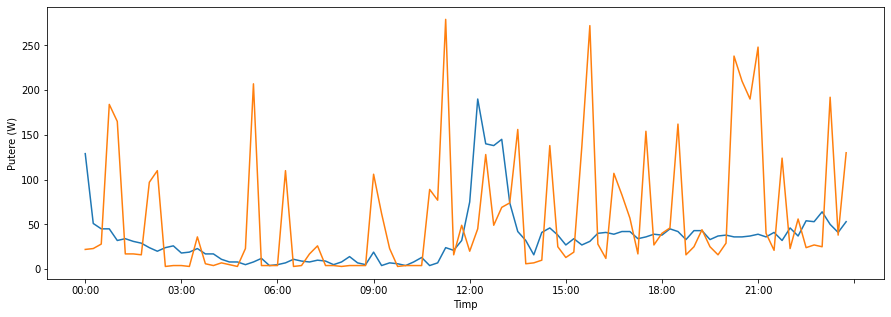

(75.82202296606617,
 array([129.,  51.,  45.,  45.,  32.,  34.,  31.,  29.,  24.,  20.,  24.,
         26.,  18.,  19.,  23.,  17.,  17.,  11.,   8.,   8.,   5.,   8.,
         12.,   4.,   5.,   7.,  11.,   9.,   8.,  10.,   9.,   5.,   8.,
         14.,   7.,   5.,  19.,   4.,   7.,   6.,   4.,   8.,  13.,   4.,
          7.,  24.,  21.,  32.,  75., 190., 140., 138., 145.,  74.,  42.,
         32.,  16.,  41.,  46.,  38.,  27.,  34.,  27.,  31.,  40.,  41.,
         39.,  42.,  42.,  34.,  36.,  39.,  38.,  45.,  42.,  33.,  43.,
         43.,  33.,  37.,  38.,  36.,  36.,  37.,  39.,  36.,  41.,  32.,
         46.,  37.,  54.,  53.,  64.,  50.,  41.,  53.]))

In [9]:
get_median_day_prediction(1, 1589500800, 35, True)


In [10]:
def test_predictor(f):
    tests = []
    no_days = 56
    for i in range(no_days):
        tests.append([])

    for day in range(7):
        ts = day * 24 * 3600 + TIMESTAMP

        for learn in range(1, no_days + 1):
            rmse, pred = f(1, ts, learn)
            tests[learn-1].append(rmse)

    day = 1
    rmse = []
    for test in tests:
        # print("No. of learning days:", day, ", RMSE:", np.average(test))
        day += 1
        rmse.append(np.average(test))

    print("Min. error:", np.min(rmse))
    print("Optimum days number:", rmse.index(np.min(rmse)) + 1)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(range(1, no_days + 1), rmse)
    plt.xlabel('Număr de zile folosite în calculul predicției')
    plt.ylabel('RMSE')
    plt.show()

Min. error: 80.83447204266122
Optimum days number: 35


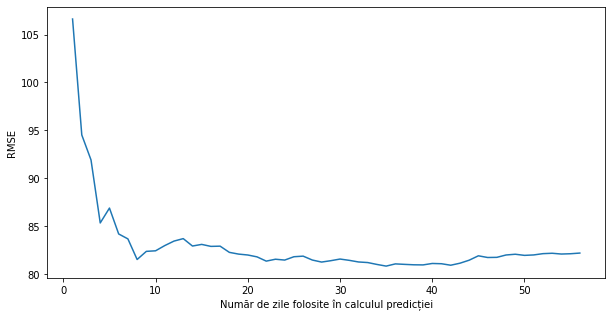

In [11]:
test_predictor(get_median_day_prediction)

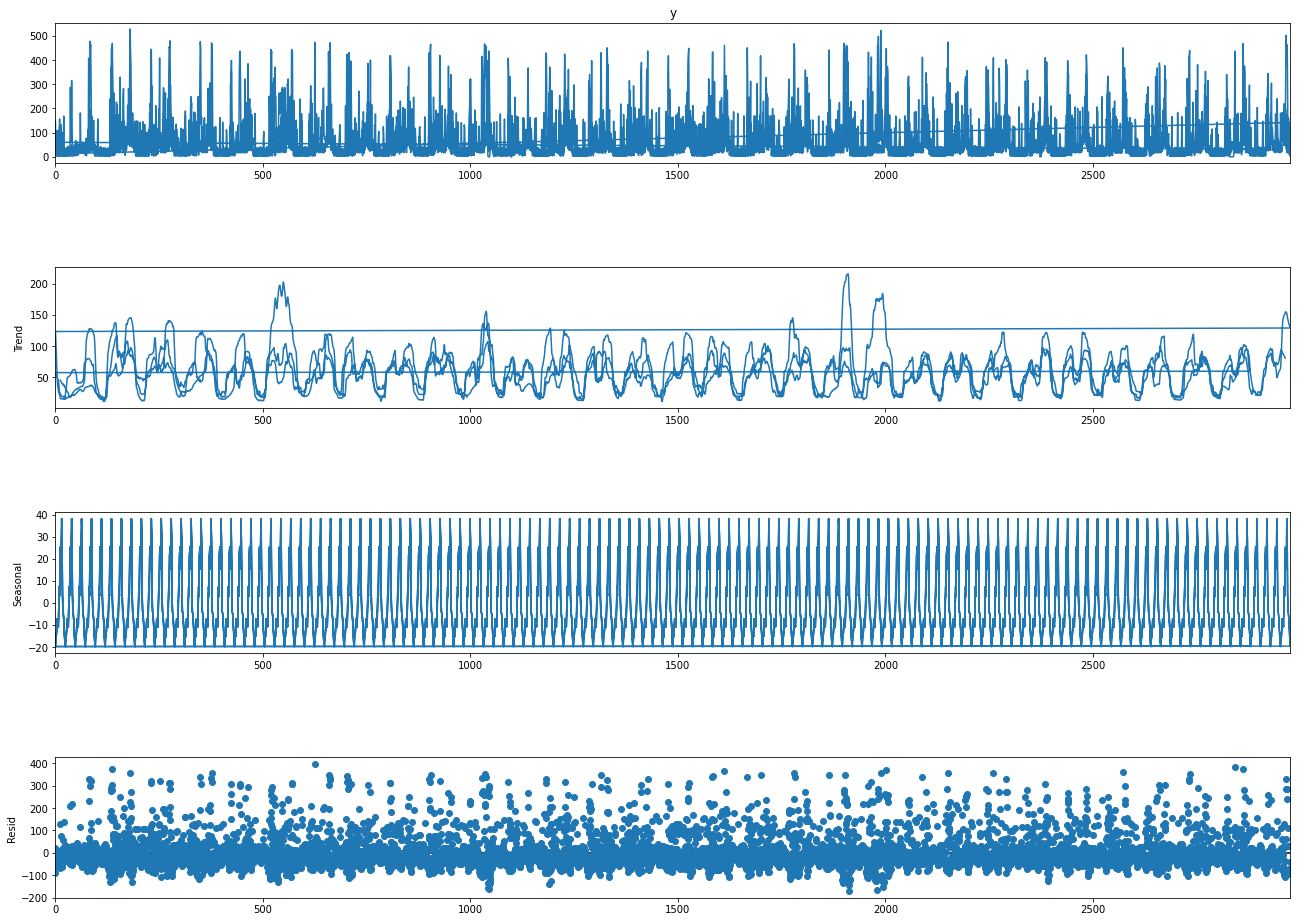

In [12]:
s = get_df_by_id(1).rename(columns={'timestamp': 'ds', 'value': 'y'})
s['ds'] = pd.to_datetime(s['ds'], unit='s')
s = s[['ds', 'y']].head(24*4*92)
result = seasonal_decompose(s['y'], model='aditive', period=24)
fig = result.plot()
fig.set_figheight(15)
fig.set_figwidth(20)

In [13]:
def get_sarima_prediction(id, timestamp, learning_days, do_plot=False):
    ts = pd.to_datetime(timestamp, unit='s')
    df = get_df_by_id(id)
    s = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
    s['ds'] = pd.to_datetime(s['ds'], unit='s')
    s = s[['ds', 'y']]
    y_true = s.loc[(s['ds'] - ts <= pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts > pd.Timedelta(0, 's'))]['y'].values
    y = s.loc[(ts - s['ds'] <= pd.Timedelta(learning_days, 'D')) &
              (ts - s['ds'] > pd.Timedelta(0, 's'))]

    model = SARIMAX(y['y'].values, order=(2, 1, 1),
                    seasonal_order=(1, 0, 1, 12), )
    model_fit = model.fit(disp=0)
    pred = model_fit.predict(
        len(y), len(y) + 24*4 - 1)

    rmse = np.sqrt(
        mean_squared_error(y_true, pred))

    if do_plot:
        fig, ax = plt.subplots(figsize=(15, 5))
        plt.plot(ts_to_hour([x for x in range(96)]), pred)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
        plt.plot(ts_to_hour([x for x in range(96)]), y_true)
        plt.xlabel("Timp")
        plt.ylabel("Putere (W)")
        plt.show()

    return rmse, pred


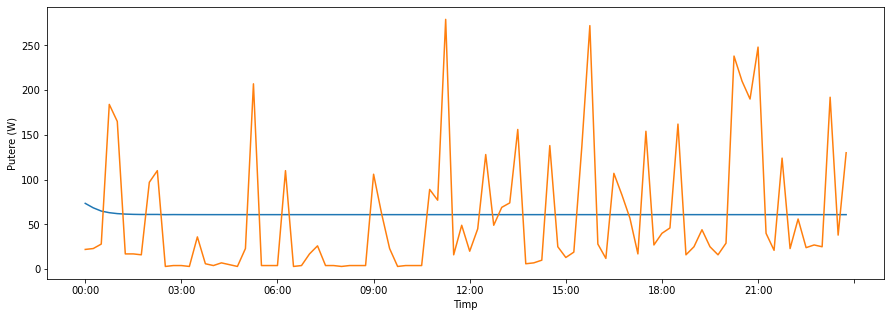

(69.48649352902439,
 array([73.45641468, 68.48176268, 64.86830291, 63.05047906, 62.01135439,
        61.47491835, 61.18565251, 61.02897765, 61.08271538, 61.08327785,
        60.84780671, 60.93361481, 60.89698783, 60.87774188, 60.87029181,
        60.86756383, 60.8639231 , 60.86340776, 60.86324509, 60.86317171,
        60.87105365, 60.87369797, 60.86167222, 60.86734022, 60.86566652,
        60.86479423, 60.86449179, 60.86440274, 60.86423107, 60.86422128,
        60.86422265, 60.86422424, 60.86467737, 60.86483003, 60.8641444 ,
        60.86446849, 60.86437321, 60.86432356, 60.86430637, 60.86430133,
        60.86429155, 60.86429101, 60.86429109, 60.86429119, 60.86431706,
        60.86432578, 60.86428663, 60.86430514, 60.8642997 , 60.86429686,
        60.86429588, 60.86429559, 60.86429504, 60.864295  , 60.86429501,
        60.86429501, 60.86429649, 60.86429699, 60.86429475, 60.86429581,
        60.8642955 , 60.86429534, 60.86429528, 60.86429527, 60.86429523,
        60.86429523, 60.8642952

In [14]:
get_sarima_prediction(1, 1589500800, 27, True)


In [15]:
from pmdarima.arima import auto_arima

s = get_df_by_id(1).rename(columns={'timestamp': 'ds', 'value': 'y'})
ts = pd.to_datetime(TIMESTAMP, unit='s')
s['ds'] = pd.to_datetime(s['ds'], unit='s')
s = s[['ds', 'y']]
y_true = s.loc[(s['ds'] - ts <= pd.Timedelta(1, 'D')) &
                (s['ds'] - ts > pd.Timedelta(0, 's'))]['y'].values
y = s.loc[(ts - s['ds'] <= pd.Timedelta(28, 'D')) &
            (ts - s['ds'] > pd.Timedelta(0, 's'))]

model = auto_arima(y['y'].values, start_p=1, start_q=1,
                      test='adf',
                    #   max_p=5, max_q=5,        
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=31020.684, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=31627.857, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=31033.662, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=31153.306, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32690.979, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=31014.962, Time=1.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=31025.071, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=31016.120, Time=0.55 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=31014.659, Time=0.88 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=31012.797, Time=1.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=31082.590, Time=0.78 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=31014.416, Time=1.56 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=31042.552, Time=1.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=31016.089, Time=1.03 sec
 ARIMA(1,0,2)(0,0,0

In [ ]:
test_predictor(get_sarima_prediction)

In [ ]:
def get_prophet_prediction(id, timestamp, learning_days, do_plot=False):
    ts = pd.to_datetime(timestamp, unit='s')
    df = get_df_by_id(id)
    s = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
    s['ds'] = pd.to_datetime(s['ds'], unit='s')
    s = s[['ds', 'y']]
    y_true = s.loc[(s['ds'] - ts <= pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts > pd.Timedelta(0, 's'))]['y'].values
    y = s.loc[(ts - s['ds'] <= pd.Timedelta(learning_days, 'D')) &
              (ts - s['ds'] > pd.Timedelta(0, 's'))]

    m = prophet.Prophet(changepoint_prior_scale=0.1,
                        seasonality_prior_scale=10.0).fit(s)

    future = m.make_future_dataframe(periods=24 * (learning_days + 1), freq='15min')
    fcst = m.predict(future)
    pred = fcst['yhat'][-24*4:].values

    rmse = np.sqrt(
        mean_squared_error(y_true, pred))

    if do_plot:
        fig, ax = plt.subplots(figsize=(15, 5))
        plt.plot(ts_to_hour([x for x in range(96)]), pred)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
        plt.plot(ts_to_hour([x for x in range(96)]), y_true)
        plt.xlabel("Timp")
        plt.ylabel("Putere (W)")
        plt.show()

    return rmse, pred


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


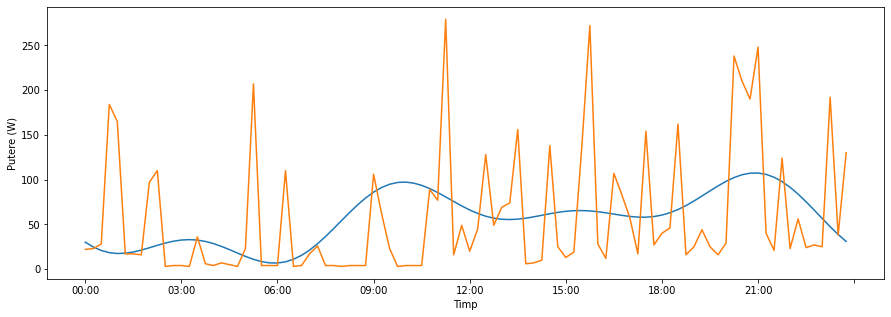

(69.47935323489469,
 array([ 30.10209264,  24.73364489,  20.83450151,  18.42999731,
         17.45461817,  17.75824174,  19.11787191,  21.25408402,
         23.8510835 ,  26.57903928,  29.11720143,  31.17625935,
         32.51844772,  32.97405724,  32.45324758,  30.95237364,
         28.5544029 ,  25.42339656,  21.79342376,  17.95264978,
         14.22366132,  10.94134271,   8.42977943,   6.97972963,
          6.82816476,   8.14124178,  11.00183896,  15.40248273,
         21.24413308,  28.34090572,  36.43041524,  45.18905194,
         54.2511813 ,  63.23099943,  71.74560825,  79.43780154,
         85.99708112,  91.17755   ,  94.81154628,  96.81817356,
         97.20623023,  96.07141733,  93.58808793,  89.9961625 ,
         85.58415223,  80.66948262,  75.57747726,  70.62043535,
         66.07821192,  62.18158861,  59.0995149 ,  56.93101932,
         55.70225659,  55.36879419,  55.82287475,  56.90504462,
         58.41923819,  60.15017213,  61.88174995,  63.41511602,
         64.58503262

In [ ]:
get_prophet_prediction(1, 1589500800, 19, True)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

Min. error: 69.47935323489469
Optimum days number: 19


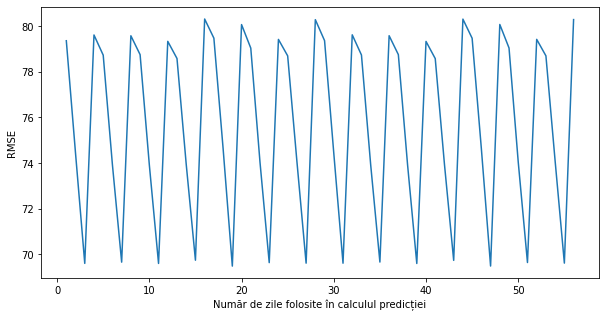

In [ ]:
test_predictor(get_prophet_prediction)

In [17]:
def generate(id, daysno = 19):
    dfs = []

    for y in ['2019', '2020']:
        for m in ['03', '04', '05']:
            dfs.append(pd.read_csv('background' + '/' +
                       y + '/' + m + '/' + str(id) + '.csv'))

    df = pd.concat(dfs)

    ts = pd.to_datetime(TIMESTAMP, unit='s')
    s = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
    s['ds'] = pd.to_datetime(s['ds'], unit='s')
    s = s.loc[(ts - s['ds'] < pd.Timedelta(daysno, 'D')) &
              (ts - s['ds'] > pd.Timedelta(1, 's'))]
    s = s[['ds', 'y']]


    m = prophet.Prophet(changepoint_prior_scale=0.1,
                        seasonality_prior_scale=10.0).fit(s)

    future = m.make_future_dataframe(periods=24 * (daysno + 1), freq='15min')
    fcst = m.predict(future)
    y_hat = fcst['yhat'][-24*4:].values
    s = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
    s['ds'] = pd.to_datetime(s['ds'], unit='s')

    y = s.loc[(s['ds'] - ts < pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts >= pd.Timedelta(0, 's'))]
    y_true = s.loc[(s['ds'] - ts < pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts >= pd.Timedelta(0, 's'))]['y'].values
    y_before = s.loc[(s['ds'] - ts < pd.Timedelta(2, 'D')) &
                     (s['ds'] - ts >= pd.Timedelta(1, 'D'))]['y'].values

    mae = mean_absolute_error(y_true, y_hat)
    print('MAE (19 days learning): %.5f' % mae)
    mae = mean_absolute_error(y_true, y_before)
    print('MAE (day before): %.5f' % mae)
    
    pred = pd.DataFrame(data={'timestamp': y['ds'].values, 'value': y_hat})
    makeDir(SCENARIO_FOLDER + "/baseline/")
    makeDir(SCENARIO_FOLDER + "/baseline/" + str(year))
    makeDir(SCENARIO_FOLDER + "/baseline/" + str(year) + "/" + f'{month:02d}')
    pred.to_csv(SCENARIO_FOLDER + "/baseline/" + str(year) +
                "/" + f'{month:02d}' + "/" + str(id) + ".csv")

    tru = s.loc[(s['ds'] - ts < pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts >= pd.Timedelta(0, 's'))]
    tru = tru.rename(columns={'ds': 'timestamp', 'y': 'value'})
    
    makeDir(SCENARIO_FOLDER + "/background/")
    makeDir(SCENARIO_FOLDER + "/background/" + str(year))
    makeDir(SCENARIO_FOLDER + "/background/" + str(year) + "/" + f'{month:02d}')
    tru.to_csv(SCENARIO_FOLDER + "/background/" + str(year) +
                "/" + f'{month:02d}' + "/" + str(id) + ".csv")

    plt.figure(figsize=(30, 5))
    plt.plot(pred['value'].values)
    plt.plot(y_true)
    plt.show()


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 61.82450
MAE (day before): 72.86458


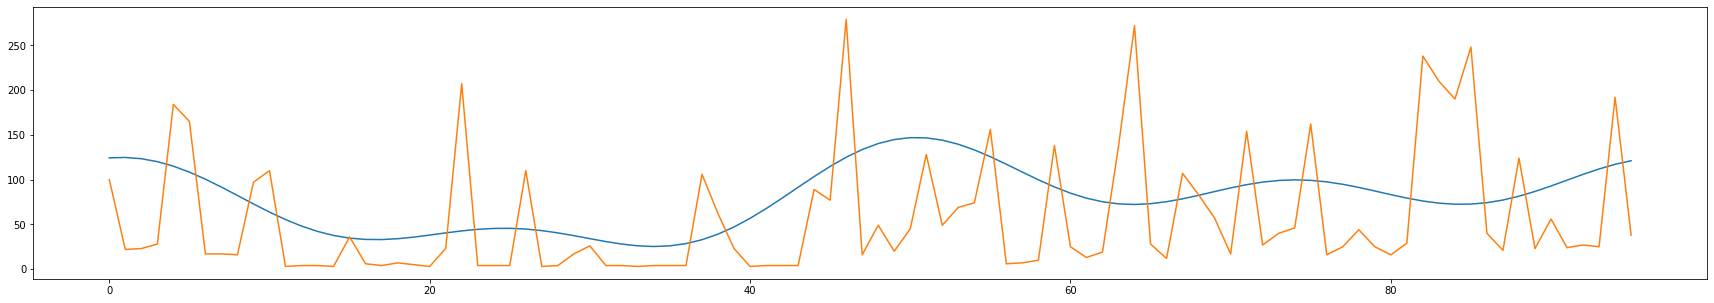

In [18]:
generate(1)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 21.84971
MAE (day before): 64.00000


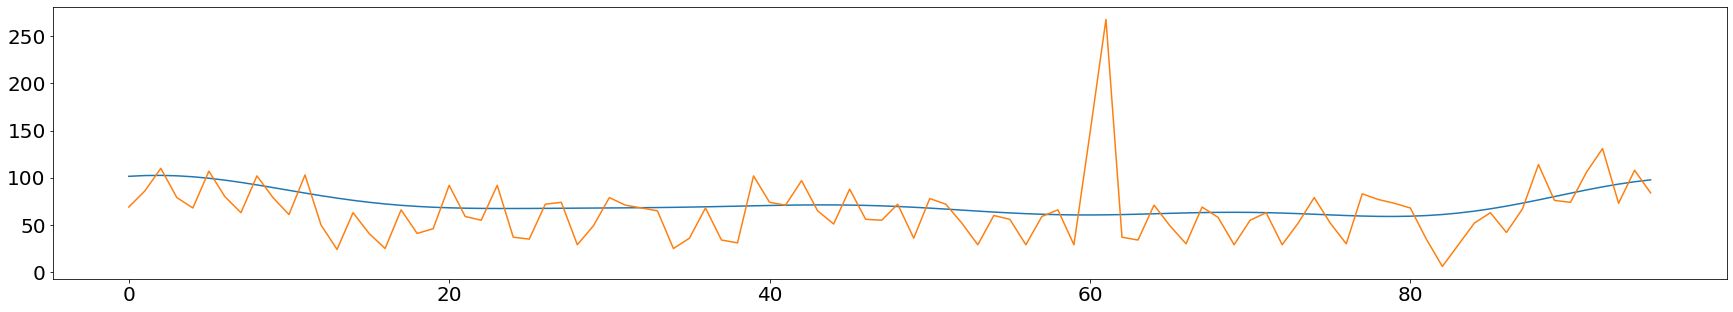

In [ ]:
generate(2)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 86.92149
MAE (day before): 87.48958


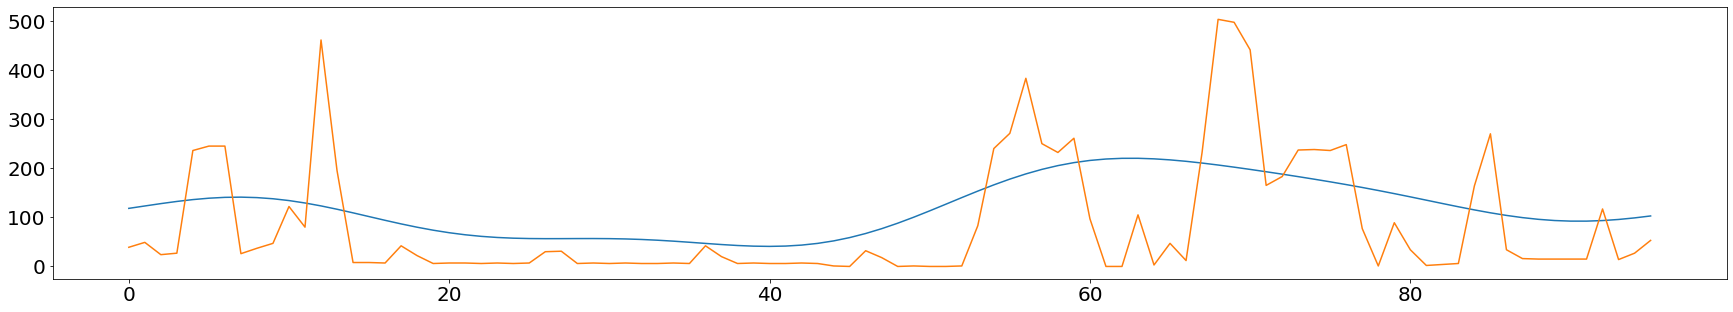

In [ ]:
generate(6)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 71.38061
MAE (day before): 65.00000


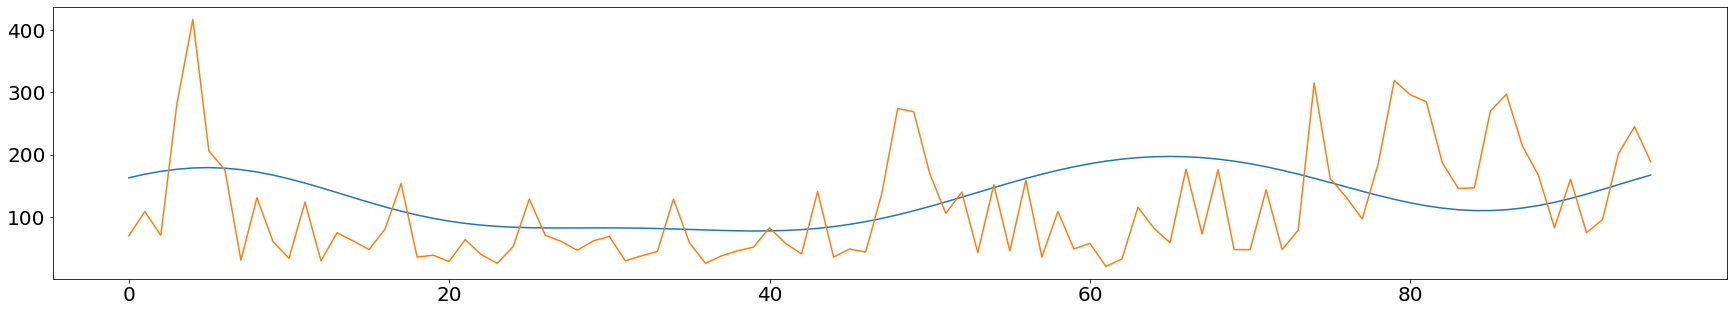

In [ ]:
generate(9)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 26.28004
MAE (day before): 27.87500


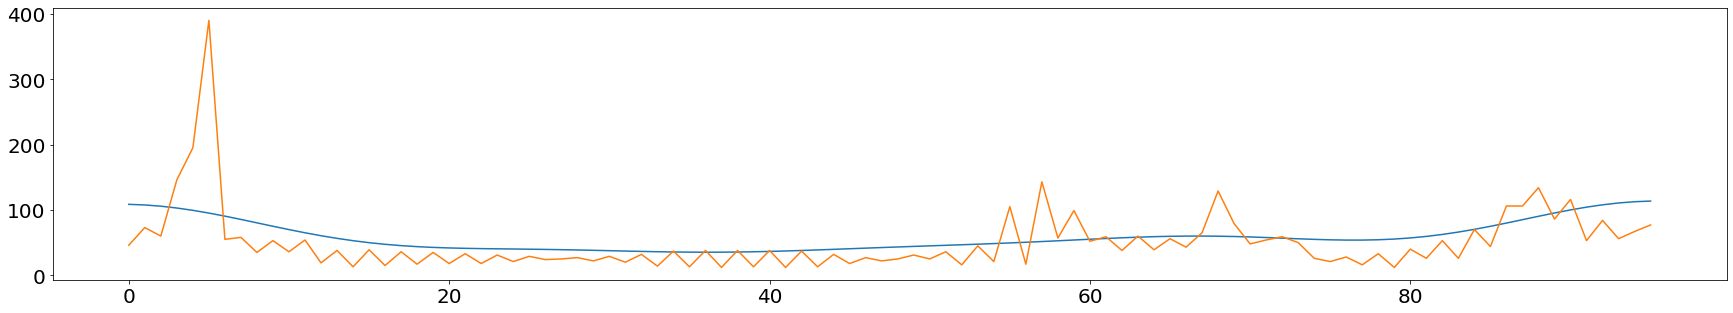

In [ ]:
generate(15)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 21.67243
MAE (day before): 29.72917


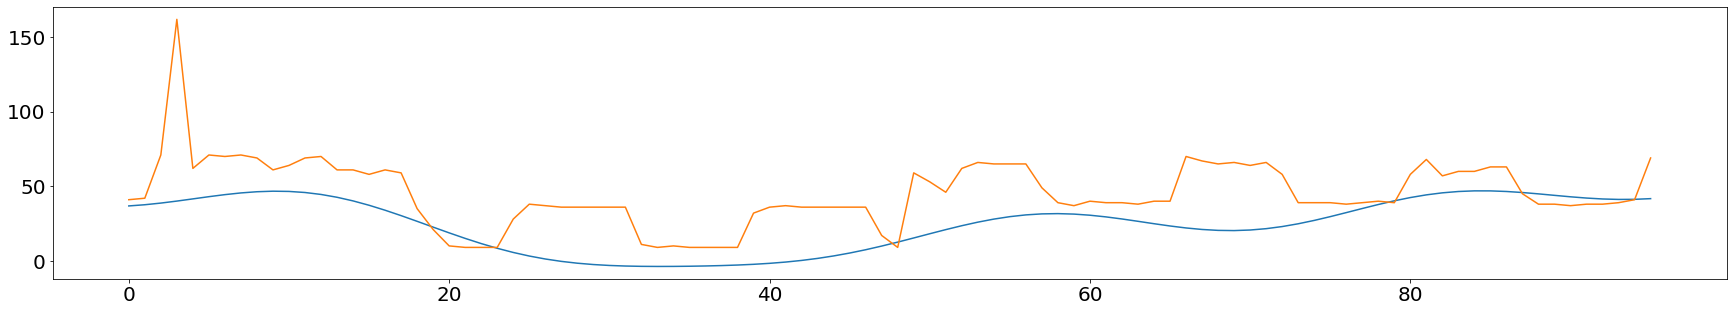

In [ ]:
generate(16)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 26.87584
MAE (day before): 28.30208


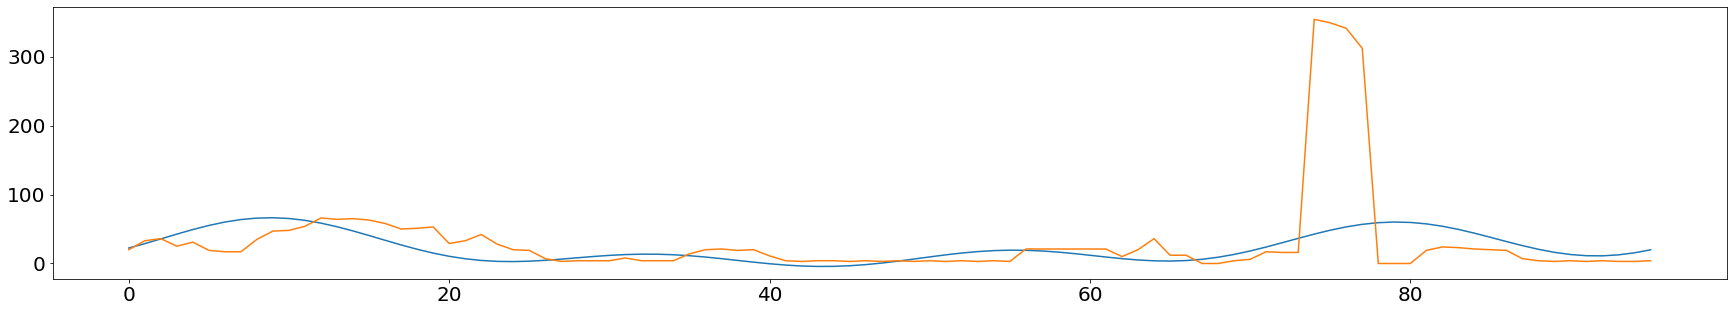

In [ ]:
generate(17)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (19 days learning): 67.29588
MAE (day before): 81.90625


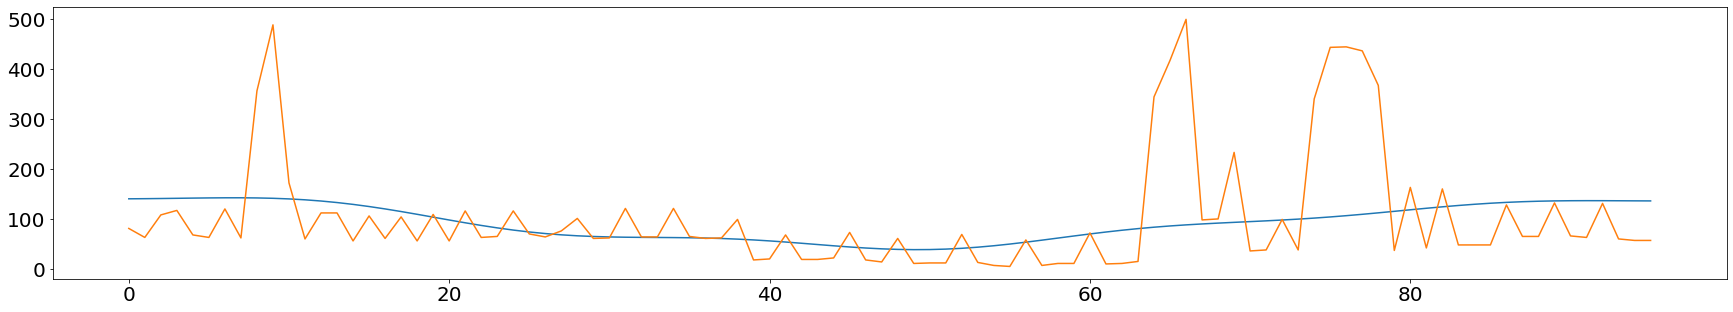

In [ ]:
generate(18)


In [19]:
def secondsToString(x):
    m, s = divmod(x, 60)
    h, m = divmod(m, 60)
    return f'{h:d}:{m:02d}'

86400
86400
86400
86400
86400
86400


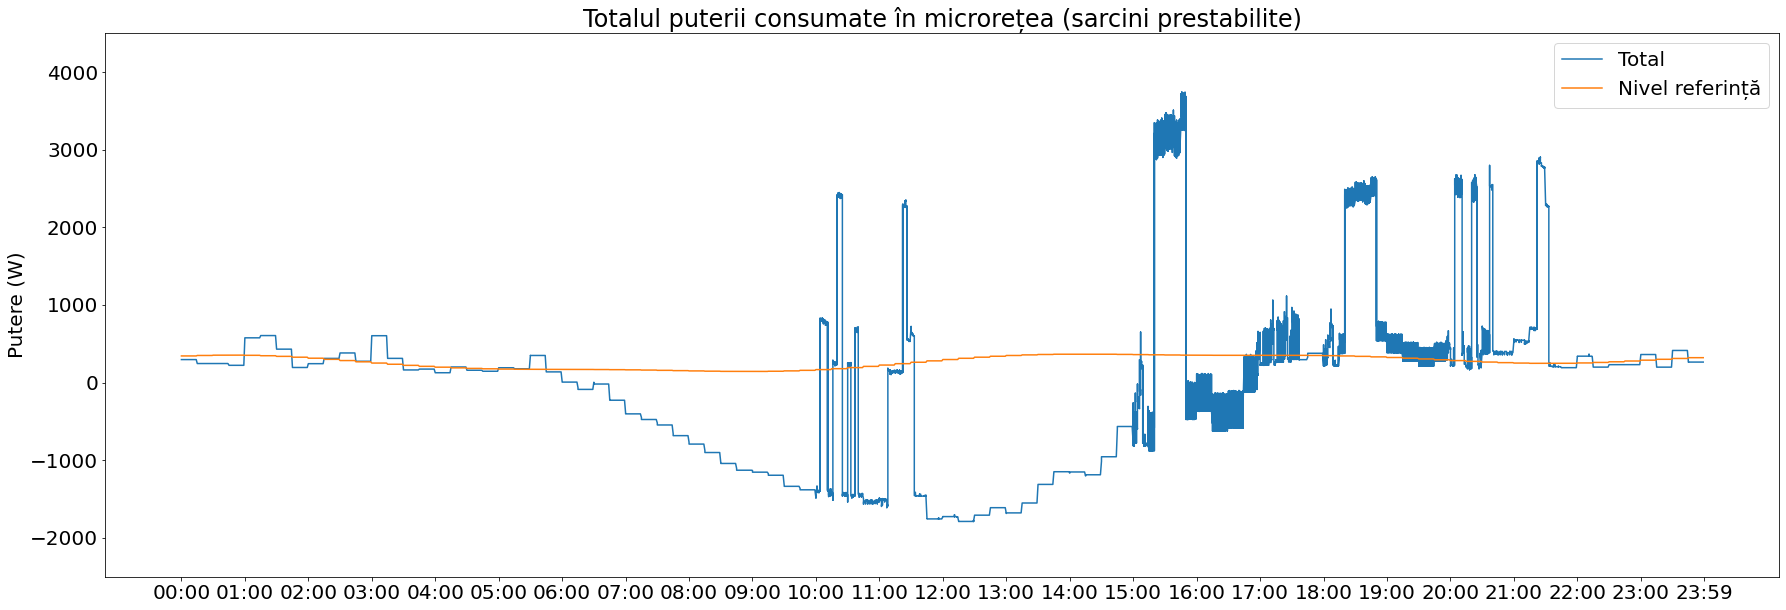

Accumulated imbalance: (kWh) 16.882419598122475
3741.54558688175 -34.322128913670014
86400


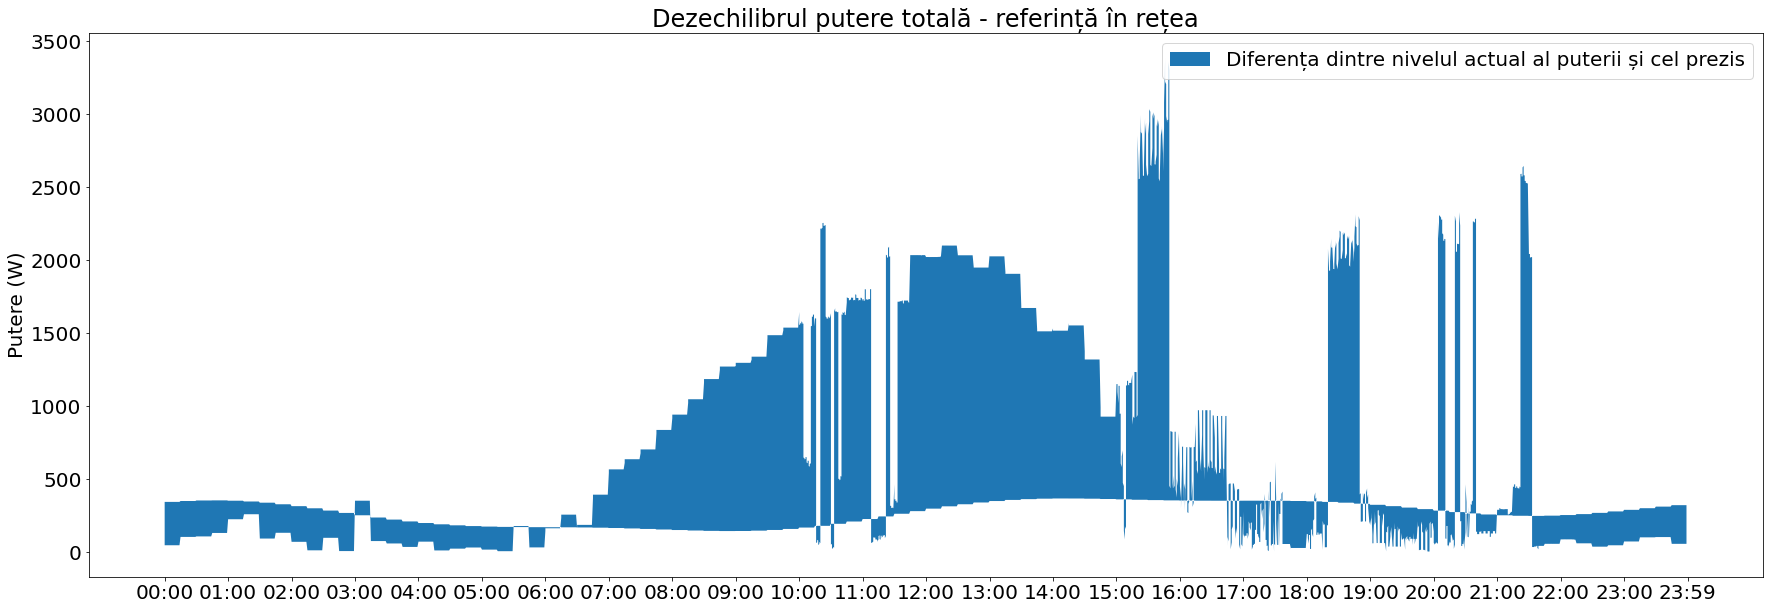

In [43]:
plt.rcParams['font.size'] = 20

totals = []

def plot_grid(ids):
    total_grid = None
    baseline_grid = None
    for id in ids:
        df = pd.read_csv(SCENARIO_FOLDER + "/background/" + str(year) +
                         "/" + f'{month:02d}' + "/" + str(id) + ".csv")
        dfbase = pd.read_csv(SCENARIO_FOLDER + "/baseline/" + str(year) +
                             "/" + f'{month:02d}' + "/" + str(id) + ".csv")
        background = []
        for i in df['value']:
            background = np.concatenate((background, np.ones(15 * 60) * i))
        print(len(background))
        total = background
        line = []
        for i in dfbase['value']:
            line = np.concatenate((line, np.ones(15 * 60) * i))
        baseline = line
        config = json.load(open('scenario/' + id + '/config.json'))
        for task in config['tasks']:
            neg = 1
            try:
                file = 'appliances/' + task['category'] + '/' + task['appliance'] + '/' + task['program'] + '/' + os.listdir(
                    'appliances/' + task['category'] + '/' + task['appliance'] + '/' + task['program'] + '/')[0]
            except:
                file = 'appliances/' + \
                    task['category'] + '/' + task['appliance'] + '/' + \
                    str(year - 1) + f'{month:02}' + f'{day:02}' + ".csv"
                neg = -1
            try:
                df = pd.read_csv(file)
                if 'timestamp' in df.columns.values:
                    df['timestamp'] = pd.to_datetime(df['timestamp'])
                    df = df.set_index('timestamp')
                    df = df.resample('1S').ffill()
                arr = np.concatenate(
                    (np.zeros(task['offset']), df['value'].values))
                arr = np.concatenate((arr, np.zeros(86400 - len(arr))))
                total += arr * neg

            except:
                for p in config["setup"][task["category"]][task["appliance"]]:
                    if p["programName"] == task['program']:
                        neg = 1 if p['generatesPower'] == "False" else -1
                        if p['duration'] == -1:
                            arr = p["averagePower"] * np.ones(3600 * 24)
                        else:
                            arr = p["averagePower"] * \
                                np.ones(p['duration'])
                            arr = np.concatenate(
                                (np.zeros(task['offset']), arr))
                            arr = np.concatenate(
                                (arr, np.zeros(86400 - len(arr))))
                        total += arr * neg
        
        if total_grid is None:
            total_grid = total
        else:
            total_grid += total

        totals.append(total)
        print(len(total))

        if baseline_grid is None:
            baseline_grid = baseline
        else:
            baseline_grid += baseline

    time = [secondsToString(x) for x in range(0, 86400)]
    plt.figure(figsize=(30, 10))
    plt.xticks(ticks=range(0, 25*60, 60), labels=['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
               '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '23:59'])
    plt.plot(time, total_grid, label='Total')
    plt.plot(time, baseline_grid, label='Nivel referință')
    plt.legend()
    plt.ylabel('Putere (W)')
    plt.title("Totalul puterii consumate în microrețea (sarcini prestabilite)")
    plt.ylim(-2500, 4500)
    plt.show()
    plt.figure(figsize=(30, 10))
    plt.xticks(ticks=range(0, 25*60, 60), labels=['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
               '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '23:59'])
    # plt.plot(time, total - baseline, label='Imbalance')
    # plt.plot(time, baseline, label='Baseline')
    plt.fill_between(time, np.abs(total_grid - baseline_grid), baseline_grid, label="Diferența dintre nivelul actual al puterii și cel prezis")
    plt.legend()
    
    plt.ylabel('Putere (W)')
    plt.title("Dezechilibrul putere totală - referință în rețea")
    print("Accumulated imbalance: (kWh)",
          (abs(total_grid - baseline_grid)).sum() / (1000 * 3600))
    # print("Peak to average power ratio: (dB)", 10 *
    #       math.log10(total.max() / total.mean()))
    print(total_grid.max(), total_grid.mean())

    np.savetxt('1.txt', totals[0])
    print(len(totals[0]))

plot_grid(["1", "2", "6"])
